In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deceiptive-patterns/patterns.csv
/kaggle/input/deceiptive-patterns/pattern_classifications.csv


In [13]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from joblib import dump

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Load both datasets
df1 = pd.read_csv("/kaggle/input/deceiptive-patterns/pattern_classifications.csv")
df2 = pd.read_csv("/kaggle/input/deceiptive-patterns/patterns_updated.csv")

# Prepare classification dataset
df1 = df1[pd.notnull(df1["Pattern String"])]
df1 = df1[df1["classification"] == 0]
df1["classification"] = "Not Dark"
df1.drop_duplicates(subset="Pattern String", inplace=True)

# Prepare patterns dataset
df2 = df2[pd.notnull(df2["Pattern String"])]
df2["classification"] = "Dark"

# Select only necessary columns
df1 = df1[['Pattern String', 'classification']]
df2 = df2[['Pattern String', 'classification']]

# Combine both datasets
df = pd.concat([df1, df2])

print(df.head())  # Check data format


                                      Pattern String classification
0                 FREE SHIPPING ON ORDERS OVER $100!       Not Dark
1                 SOME EXCLUSIONS APPLY - LEARN MORE       Not Dark
2                      HAVE A QUESTION? - CONTACT US       Not Dark
3                          WELCOME TO 034MOTORSPORT!       Not Dark
4  SHOP AUDISHOP VOLKSWAGENPERFORMANCE SOFTWARE03...       Not Dark


In [15]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df['Pattern String'] = df['Pattern String'].apply(clean_text)

In [16]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Pattern String'])
X = tokenizer.texts_to_sequences(df['Pattern String'])

# Padding
X = pad_sequences(X, maxlen=50, padding="post")

# Encode Labels
label_encoder = LabelEncoder()
df['classification'] = label_encoder.fit_transform(df['classification'])
y = df['classification']

# Save tokenizer and label encoder for API use
dump(tokenizer, 'tokenizer.joblib')
dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=50),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification (Dark/Not Dark)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model
# model.save("dark_pattern_nn.h5")

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8235 - loss: 0.5243 - val_accuracy: 0.8116 - val_loss: 0.4853
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8227 - loss: 0.4796 - val_accuracy: 0.8116 - val_loss: 0.4877
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8101 - loss: 0.5009 - val_accuracy: 0.8116 - val_loss: 0.4881
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8361 - loss: 0.4492 - val_accuracy: 0.8116 - val_loss: 0.4825
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8041 - loss: 0.5068 - val_accuracy: 0.8134 - val_loss: 0.4854
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8337 - loss: 0.4632 - val_accuracy: 0.8134 - val_loss: 0.4816
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8149 - loss: 0.4832 - val_accuracy: 0.8134 - val_loss: 0.4859
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8316 - loss: 0.4579 - val_accuracy: 0.8134 - v

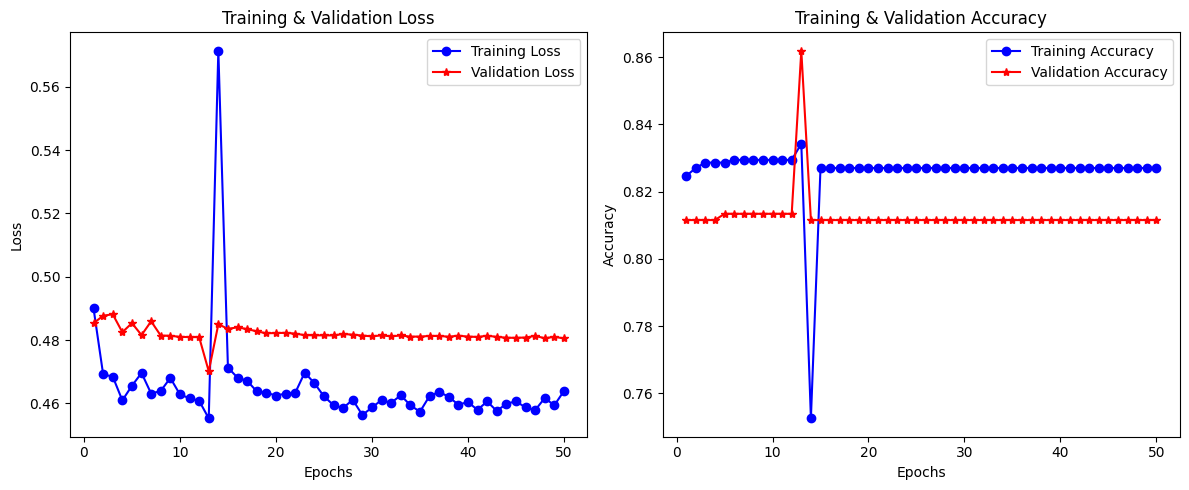

In [20]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
model.save("model.h5")

In [21]:
# Evaluate on Test Data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7973 - loss: 0.5023
Test Accuracy: 0.8116


# Approach 2

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7512 - loss: 0.5710 - val_accuracy: 0.8228 - val_loss: 0.5477 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8451 - loss: 0.3650 - val_accuracy: 0.8228 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9245 - loss: 0.2379 - val_accuracy: 0.8228 - val_loss: 0.4049 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9696 - loss: 0.1196 - val_accuracy: 0.8489 - val_loss: 0.3557 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9812 - loss: 0.0884 - val_accuracy: 0.8881 - val_loss: 0.3283 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9785 - loss: 0.1125 - val_accuracy: 0.9571 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9883 - loss: 0.0483 - val_accuracy: 0.96

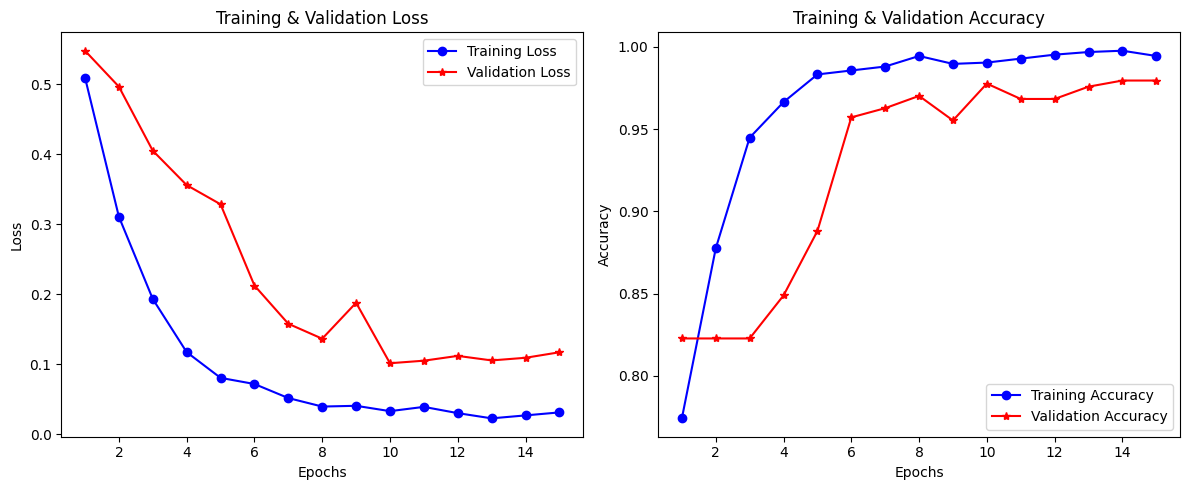

In [22]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from joblib import dump

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the datasets
df1 = pd.read_csv("/kaggle/input/deceiptive-patterns/pattern_classifications.csv")
df2 = pd.read_csv("/kaggle/input/deceiptive-patterns/patterns_updated.csv")

# Data Preparation
df1 = df1[pd.notnull(df1["Pattern String"])]
df1 = df1[df1["classification"] == 0]
df1["classification"] = "Not Dark"
df1.drop_duplicates(subset="Pattern String", inplace=True)

df2 = df2[pd.notnull(df2["Pattern String"])]
df2["classification"] = "Dark"

# Select only necessary columns
df1 = df1[['Pattern String', 'classification']]
df2 = df2[['Pattern String', 'classification']]

# Combine datasets
df = pd.concat([df1, df2])
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset

# Text Cleaning Function
def clean_text(text):
    text = str(text).lower().strip()  # Lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"\W+", " ", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

df['Pattern String'] = df['Pattern String'].apply(clean_text)

# Tokenization and Padding
max_words = 5000  # Max vocabulary size
maxlen = 50  # Max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Pattern String'])
X = tokenizer.texts_to_sequences(df['Pattern String'])
X = pad_sequences(X, maxlen=maxlen, padding="post")

# Encode Labels
label_encoder = LabelEncoder()
df['classification'] = label_encoder.fit_transform(df['classification'])
y = df['classification']

# Save Tokenizer and Label Encoder
dump(tokenizer, 'tokenizer.joblib')
dump(label_encoder, 'label_encoder.joblib')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=maxlen),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification (Dark/Not Dark)
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-5)

# Train Model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

import matplotlib.pyplot as plt

# Extract accuracy and loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Evaluate on Test Data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9801 - loss: 0.0904
Test Accuracy: 0.9776


In [24]:
# model.save("model.h5")

# With updated dataset

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.2334 - loss: 2.0830 - val_accuracy: 0.8228 - val_loss: 1.5082 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6364 - loss: 1.0272 - val_accuracy: 0.8228 - val_loss: 1.2388 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8060 - loss: 0.5997 - val_accuracy: 0.8228 - val_loss: 1.0625 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8816 - loss: 0.4071 - val_accuracy: 0.8489 - val_loss: 0.9497 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9062 - loss: 0.3300 - val_accuracy: 0.8731 - val_loss: 0.9385 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9379 - loss: 0.2556 - val_accuracy: 0.9086 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9562 - loss: 0.1895 - val_ac

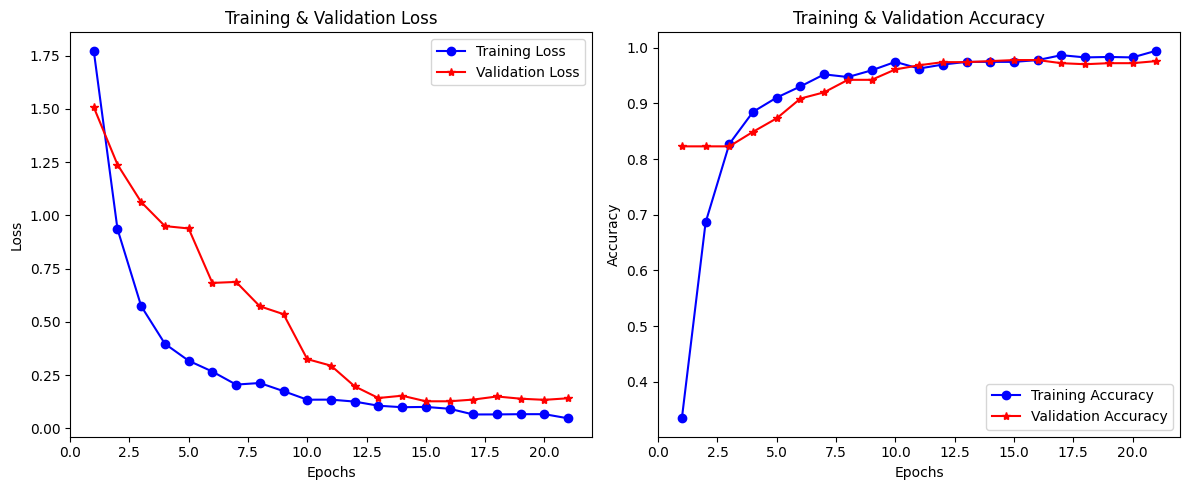

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from joblib import dump

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the datasets
df1 = pd.read_csv("/kaggle/input/deceiptive-patterns/pattern_classifications.csv")
df2 = pd.read_csv("/kaggle/input/deceiptive-patterns/patterns.csv")

# Data Preparation
df1 = df1[pd.notnull(df1["Pattern String"])]
df1 = df1[df1["classification"] == 0]  # Only "Not Dark"
df1["classification"] = "Not Dark"
df1.drop_duplicates(subset="Pattern String", inplace=True)

df2 = df2[pd.notnull(df2["Pattern String"])]

# Use "Pattern Category" as the classification label
df2.rename(columns={"Pattern Category": "classification"}, inplace=True)

# Select relevant columns
df1 = df1[['Pattern String', 'classification']]
df2 = df2[['Pattern String', 'classification']]

# Combine datasets
df = pd.concat([df1, df2])
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset

# Text Cleaning Function
def clean_text(text):
    text = str(text).lower().strip()  # Lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"\W+", " ", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

df['Pattern String'] = df['Pattern String'].apply(clean_text)

# Tokenization and Padding
max_words = 5000  # Max vocabulary size
maxlen = 50  # Max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Pattern String'])
X = tokenizer.texts_to_sequences(df['Pattern String'])
X = pad_sequences(X, maxlen=maxlen, padding="post")

# Encode Labels
label_encoder = LabelEncoder()
df['classification'] = label_encoder.fit_transform(df['classification'])
y = df['classification']

# Save Tokenizer and Label Encoder
dump(tokenizer, 'tokenizer.joblib')
dump(label_encoder, 'label_encoder.joblib')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define Model
num_classes = len(label_encoder.classes_)  # Multi-class output

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=maxlen),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # Multi-class classification
])

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-5)

# Train Model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Plot Training & Validation Metrics
import matplotlib.pyplot as plt

# Extract accuracy and loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
# Evaluate on Test Data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9840 - loss: 0.0901
Test Accuracy: 0.9776


In [5]:
# Save model and tokenizer
model.save("deceptive_pattern_model.h5")
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
